In [46]:
import genvarloader as gvl
import scipy.stats as st
import polars.selectors as cs
from genoray import PGEN
from genoray.exprs import is_snp, is_biallelic
from basenji2_pytorch import Basenji2, basenji2_params, basenji2_weights
import polars as pl
from typing import cast
from math import log
import seqpro as sp
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm.auto import tqdm

# Prep

In [10]:
ds_path = "/carter/users/dlaub/projects/gvl-paper/basenji2/data/geuvadis.autosomes.hg19.gvl"
basenji2_in_len = 2**17
basenji2_out_len = 896
basenji2_bin_size = 128

In [11]:
var_samples = pl.read_csv(
    "/carter/users/dlaub/data/1kGP-rna-seq/E-GEUV-3_analysis/geuvadis.psam",
    separator="\t",
)['#IID'].to_list()

In [12]:
genes = pl.read_csv(
    "/carter/users/dlaub/projects/gvl-paper/basenji2/gene_list.csv",
    has_header=False,
    new_columns=["gene_id", "chrom", "chromStart", "hgnc", "strand"],
)
genes.head()

gene_id,chrom,chromStart,hgnc,strand
str,i64,i64,str,str
"""ENSG00000000457""",1,169863408,"""SCYL3""","""-"""
"""ENSG00000001630""",7,91772266,"""CYP51A1""","""-"""
"""ENSG00000002549""",4,17578815,"""LAP3""","""+"""
"""ENSG00000002745""",7,120965421,"""WNT16""","""+"""
"""ENSG00000003056""",12,9102551,"""M6PR""","""-"""


In [13]:
sample_ids = (
    pl.scan_csv(
        "/carter/users/dlaub/data/1kGP-rna-seq/sample_id_to_bigwig.csv",
    )
    .select("path", "sample")
    .with_columns(pl.col("path").str.extract(r"(ERR\d{6})"))
    .collect()
)
expr = (
    pl.read_csv(
        "/carter/users/dlaub/data/1kGP-rna-seq/E-GEUV-3_analysis/rna/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz",
        separator="\t",
        comment_prefix="#",
    )
    .rename({"TargetID": "gene_id"})
    .drop("Gene_Symbol", "Chr", "Coord")
    .with_columns(
        pl.col("gene_id").str.split(".").list.get(0),
        (cs.numeric() / cs.numeric().sum() * int(1e6)).log1p()
        / log(2),  # log2(CPM + 1)
    )
    .join(genes, "gene_id")
    .sort("gene_id")
    .rename(dict(zip(*sample_ids)), strict=False)
)
samples = sorted(list(set(var_samples).intersection(expr.columns)))
expr = expr.select("gene_id", *samples)
assert genes.height >= expr.height
assert len(samples) == expr.width - 1
print(genes.height, expr.height, len(samples))
expr.head()

3259 3259 462


gene_id,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,HG00106,HG00108,HG00109,HG00110,HG00111,HG00112,HG00114,HG00115,HG00116,HG00117,HG00118,HG00119,HG00120,HG00121,HG00122,HG00123,HG00124,HG00125,HG00126,HG00127,HG00128,HG00129,HG00130,HG00131,HG00132,HG00133,HG00134,…,NA20770,NA20771,NA20772,NA20773,NA20774,NA20778,NA20783,NA20785,NA20786,NA20787,NA20790,NA20792,NA20795,NA20796,NA20797,NA20798,NA20799,NA20800,NA20801,NA20802,NA20803,NA20804,NA20805,NA20806,NA20807,NA20808,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ENSG00000000457""",2.931598,3.140177,2.244776,2.81148,2.837441,2.558739,3.222918,2.882317,2.99278,2.968469,2.640006,2.96404,3.178503,2.877948,3.133748,2.921671,2.960012,3.184406,2.977955,2.941812,3.255446,2.800092,3.117055,3.049827,2.922898,3.244766,2.84497,3.041862,3.06226,3.015695,2.899309,2.915384,3.326138,2.86082,2.897777,2.747475,…,3.075311,2.997922,3.151415,2.930786,2.673931,2.784277,3.348821,3.510797,3.180127,2.937587,3.063693,3.333205,3.079004,3.166981,2.7067,3.324133,3.097668,2.842835,2.697607,2.698421,2.978329,3.046703,3.144758,2.782715,3.06975,2.891104,2.893421,2.952677,2.869649,2.804927,3.255143,3.076577,2.984109,3.141895,3.186543,3.165044,3.149742
"""ENSG00000001630""",5.243522,5.254291,4.743122,5.165065,5.508409,5.436345,5.094442,5.671152,5.560941,4.958463,5.327279,5.484112,5.404432,5.298302,5.49555,5.388366,5.314826,5.335098,5.45525,5.244614,5.321617,5.559788,5.138869,5.397729,4.881141,5.142103,5.110888,4.96077,4.975971,5.362956,5.352687,5.430543,5.440641,5.439125,5.247444,5.22508,…,5.62847,5.344381,5.234146,5.171865,5.355888,5.527908,5.130563,4.876342,5.168707,5.486384,5.236632,5.39799,5.696301,5.580772,4.680338,5.5497,5.065044,5.449657,5.375687,5.391198,5.528409,5.168126,5.450947,5.603893,5.365786,5.094545,5.284731,5.36017,5.435211,5.5433,5.673632,5.212856,5.264935,5.558429,5.586847,5.492437,5.315439
"""ENSG00000002549""",6.663014,6.869873,6.340609,7.019437,6.814486,7.077219,6.861647,7.119924,7.137763,6.63782,7.056425,6.764851,7.021541,6.562665,7.105234,7.127753,6.889584,5.774006,6.74339,6.689699,7.042266,6.78297,7.361635,7.052123,6.862205,7.299658,6.9956,6.763587,6.448113,7.085797,6.758582,6.93361,6.711811,6.992169,7.115387,6.951429,…,6.813124,7.110503,6.799148,7.148959,6.623436,6.883789,6.840434,6.958998,6.633534,6.899227,6.95887,7.004662,7.036034,6.99611,6.685966,6.701324,6.810408,6.66492,6.88647,6.754432,6.843899,6.620893,6.707971,7.057052,6.882407,6.739473,6.899468,6.460921,6.864801,7.196899,6.952156,6.940546,7.10876,6.676775,6.845775,6.778758,6.7926
"""ENSG00000002745""",0.382985,0.233011,0.043301,0.221877,0.153917,0.349477,0.16196,0.026184,0.236181,0.313456,0.083506,0.306676,0.159147,0.266666,0.184163,0.243376,0.398232,0.046684,0.277083,0.127501,0.192247,0.234395,0.175509,0.240182,0.23571,0.420965,-0.067128,0.211877,0.02425,0.300218,0.323947,0.17433,0.108839,0.125412,0.666503,-0.042113,…,0.162325,0.118648,0.273519,0.116798,0.043293,0.096995,0.146344,0.098731,0.200517,0.100747,-0.032996,0.104284,0.636317,0.081165,0.064087,0.153327,0.149929,0.953069,0.04275,0.165065,0.191501,0.377184,0.016317,0.016814,0.532975,0.290175,0.073313,0.207794,0.455368,0.304623,0.097147,0.098622,0.181968,0.161204,-0.045138,0.090483,-0.074871
"""ENSG00000003056""",7.006797,6.955064,6.309078,6.814483,6.8951,7.126598,7.020002,6.917494,6.792945,6.888045,6.819,7.043565,7.054049,7.03521,7.293131,6.868421,7.070224,6.861477,6.971607,7.109891,7.09009,7.18324,6.944421,6.888635,7.024218,6.964932,6.472605,7.156976,6.881854,6.924399,7.150262,6.822055,6.892179,6.648831,6.914114,6.997049,…,7.149597,7.142139,7.190254,6.909133,6.80567,6.675559,7.198447,7.072565,7.1689

# Write

In [3]:
var = PGEN(
    "/carter/users/dlaub/data/1kGP-rna-seq/E-GEUV-3_analysis/geuvadis.pgen",
    filter=is_snp & is_biallelic & ~pl.col("ID").str.starts_with("sv"),
)

2025-05-17 12:08:24.469 | INFO     | genoray._pgen:_read_index:1077 - Loading genoray index.


In [6]:
bed = gvl.with_length(
    genes.with_columns(chromEnd=pl.col("chromStart")), basenji2_in_len + 2
).with_columns(pl.col("chrom").cast(pl.Utf8))
bed.head()

gene_id,chrom,chromStart,hgnc,strand,chromEnd
str,str,i64,str,str,i64
"""ENSG00000000457""","""1""",169797871,"""SCYL3""","""-""",169928945
"""ENSG00000001630""","""7""",91706729,"""CYP51A1""","""-""",91837803
"""ENSG00000002549""","""4""",17513278,"""LAP3""","""+""",17644352
"""ENSG00000002745""","""7""",120899884,"""WNT16""","""+""",121030958
"""ENSG00000003056""","""12""",9037014,"""M6PR""","""-""",9168088


In [8]:
gvl.write(ds_path, bed, var, samples=samples, overwrite=True)

2025-05-17 12:09:41.679 | INFO     | genvarloader._dataset._write:write:76 - Writing dataset to /carter/users/dlaub/projects/gvl-paper/basenji2/data/geuvadis.autosomes.hg19.gvl
2025-05-17 12:09:41.682 | INFO     | genvarloader._dataset._write:write:83 - Found existing GVL store, overwriting.
2025-05-17 12:09:41.875 | INFO     | genvarloader._dataset._write:write:148 - Using 462 samples.
2025-05-17 12:09:41.876 | INFO     | genvarloader._dataset._write:write:154 - Writing genotypes.


  0%|          | 0/3259 [00:00<?, ? region/s]

2025-05-17 12:11:36.939 | WARNING  | genvarloader._dataset._write:_write_from_pgen:431 - A region has no variants for any sample. This could be expected depending on the region lengths and source of variants. However, this can also be caused by a mismatch between the reference genome used for the BED file coordinates and the one used for the variants.
2025-05-17 12:13:22.579 | INFO     | genvarloader._dataset._write:write:178 - Finished writing.


# Evaluate

In [ ]:
ref = "/carter/shared/genomes/homo_sapiens/grch37.primary.fa.bgz"
ds = gvl.Dataset.open(ds_path, ref).with_len(basenji2_in_len)

2025-06-03 12:17:52.613 | INFO     | genvarloader._dataset._impl:open:201 - Loading reference genome into memory. This typically has a modest memory footprint (a few GB) and greatly improves performance.
2025-06-03 12:17:52.794 | INFO     | genvarloader._dataset._reference:from_path:84 - Memory-mapping FASTA file for faster access.


  0%|          | 0/3101804739 [00:00<?, ? nucleotide/s]

2025-06-03 12:18:27.473 | INFO     | genvarloader._dataset._reconstruct:from_path:183 - Loading variant data.
2025-06-03 12:18:32.505 | INFO     | genvarloader._dataset._impl:open:287 - Opened dataset:
GVL store at /carter/users/dlaub/projects/gvl-paper/basenji2/data/geuvadis.autosomes.hg19.gvl
Is subset: False
# of regions: 3259
# of samples: 462
Output length: ragged
Jitter: 0 (max: 0)
Deterministic: True
Sequence type: reference [haplotypes] annotated variants
Active tracks: None
Tracks available: None



In [6]:
target_df = pl.read_csv(
    "/carter/users/dlaub/projects/gvl-paper/basenji2/targets_human.tsv", separator="\t"
)
target_df.head()

index,genome,identifier,file,clip,scale,sum_stat,description
i64,i64,str,str,i64,i64,str,str
0,0,"""ENCFF833POA""","""/home/drk/tillage/datasets/hum…",32,2,"""mean""","""DNASE:cerebellum male adult (2…"
1,0,"""ENCFF110QGM""","""/home/drk/tillage/datasets/hum…",32,2,"""mean""","""DNASE:frontal cortex male adul…"
2,0,"""ENCFF880MKD""","""/home/drk/tillage/datasets/hum…",32,2,"""mean""","""DNASE:chorion"""
3,0,"""ENCFF463ZLQ""","""/home/drk/tillage/datasets/hum…",32,2,"""mean""","""DNASE:Ishikawa treated with 0.…"
4,0,"""ENCFF890OGQ""","""/home/drk/tillage/datasets/hum…",32,2,"""mean""","""DNASE:GM03348"""


In [7]:
targets = target_df.filter(pl.col("description").str.contains(r"lymphoblastoid"))[
    "index"
].to_list()
targets

[5110]

## Predict

In [11]:
ploidy = 2
# (r s p t)
pred_expr = np.memmap(
    "/carter/users/dlaub/projects/gvl-paper/basenji2/data/preds_hg19.npy",
    dtype=np.float32,
    mode="w+",
    shape=(ds.n_regions, ds.n_samples, ploidy, len(targets), basenji2_out_len),
)

In [12]:
basenji2 = Basenji2(basenji2_params["model"])
basenji2.load_state_dict(torch.load(basenji2_weights()))
basenji2 = basenji2.cuda().eval()
basenji2 = cast(Basenji2, torch.compile(basenji2))

In [13]:
def transform(haps):
    haps = sp.DNA.ohe(haps).swapaxes(-2, -1)
    return haps

batch_size = 32
with torch.no_grad(), torch.autocast("cuda"):
    for batch_idx, batch in enumerate(
        tqdm(ds.to_dataloader(batch_size, transform=transform))
    ):
        bsize = len(batch)
        s = batch_idx * batch_size
        e = s + bsize
        ds_idx = np.arange(s, e)
        r_idx, s_idx = np.unravel_index(ds_idx, ds.shape)
        batch = rearrange(batch, "b p a l -> (b p) a l").to("cuda", torch.float32)
        pred = basenji2(batch)[..., targets]
        pred = rearrange(pred, "(b p) l t -> b p t l", b=bsize)
        pred_expr[r_idx, s_idx] = pred.numpy(force=True)

  0%|          | 0/47052 [00:00<?, ?it/s]

W0517 12:35:21.009000 3198029 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


## Metrics

In [8]:
ploidy = 2
# (r s p t)
pred_expr = np.memmap(
    "/carter/users/dlaub/projects/gvl-paper/basenji2/data/preds_hg19.npy",
    dtype=np.float32,
    mode="r",
    shape=(ds.n_regions, ds.n_samples, ploidy, len(targets), basenji2_out_len),
)

In [9]:
# (g s p t l) -> (g s)
huang_expr = pred_expr[..., basenji2_out_len // 2 - 5 : basenji2_out_len // 2 + 5].mean(
    axis=(2, 3, 4)
)

NameError: name 'expr' is not defined

In [14]:
gene_rho = np.diag(
    st.spearmanr(expr[:, 1:].to_numpy(), huang_expr, axis=0).statistic, ds.n_samples
)
indiv_rho = np.diag(
    st.spearmanr(expr[:, 1:].to_numpy(), huang_expr, axis=1).statistic, ds.n_regions
)

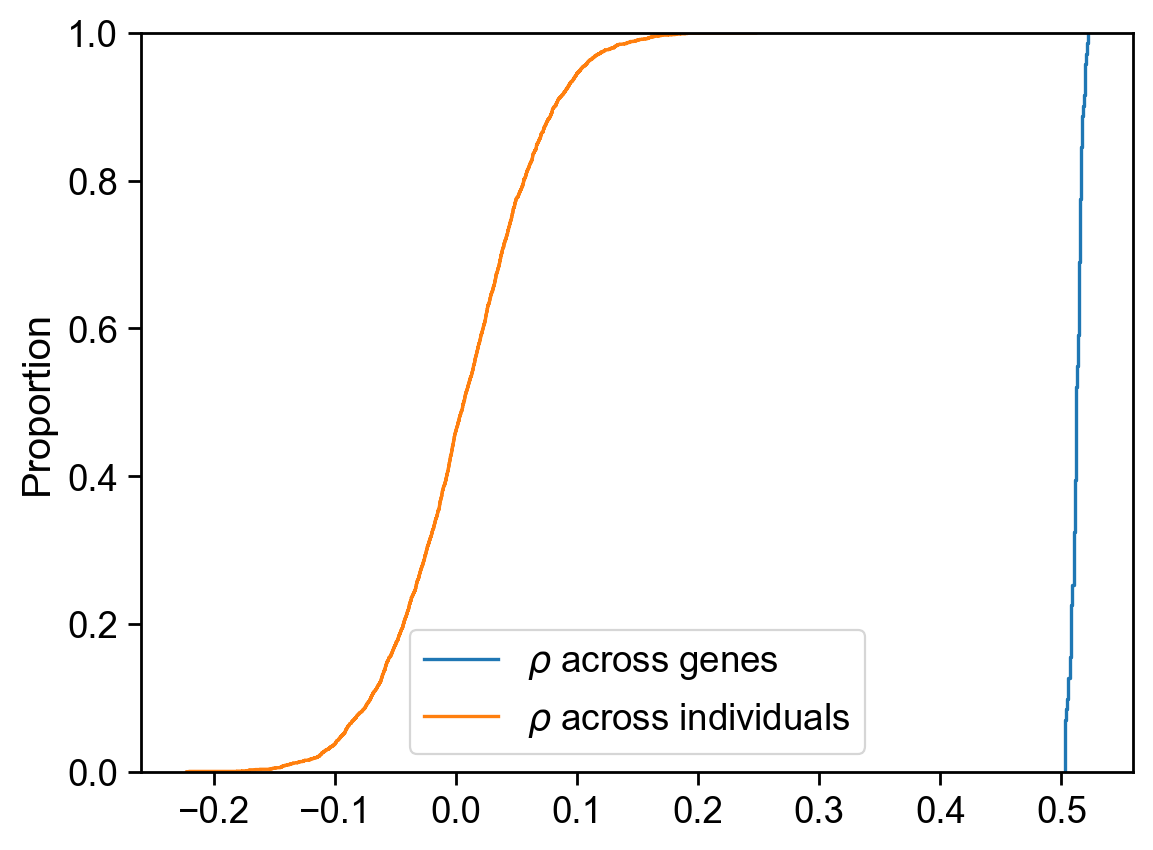

In [45]:
with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(dpi=200)
    sns.ecdfplot(gene_rho.ravel(), label=r"$\rho$ across genes", ax=ax)
    sns.ecdfplot(indiv_rho.ravel(), label=r"$\rho$ across individuals", ax=ax)
    ax.legend(loc="best")
    # ax.legend(bbox_to_anchor=(-0.05, 0), loc="lower left", transform=ax.transData)